In [4]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a large scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import *
from trips.solvers.GMRES import GMRES
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from trips.utilities.operators import *

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. Show how the forward operator can be accessed as a matrix (for relatively small problems) or only as an operator.
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [6]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels that we call views
views = 60
nx = 256
ny = 256
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'grains'
(x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny)
# Step 2: Define the forward operator
A = Tomo.forward_Op(nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(d, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = d.reshape((-1,1))

settings
no crime


###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fd1293a2280>)

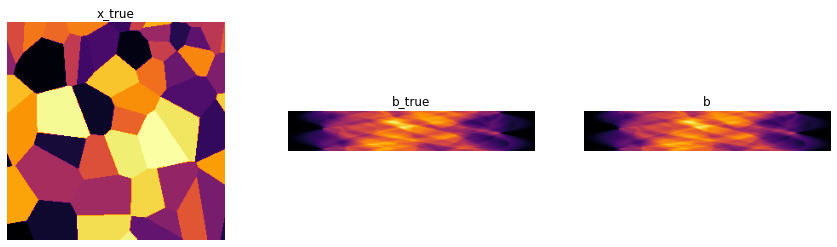

In [4]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(d.reshape((p,q)))

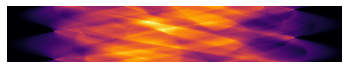

In [5]:
plt.imshow(d.reshape((p, q)))
plt.axis('off')
plt.set_cmap('inferno')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [7]:
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=2, n_iter = 100, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


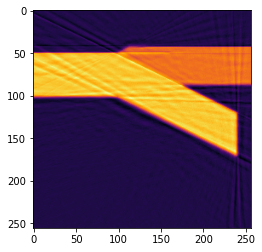

In [8]:
plt.imshow(x_gks.reshape((nx, ny)))

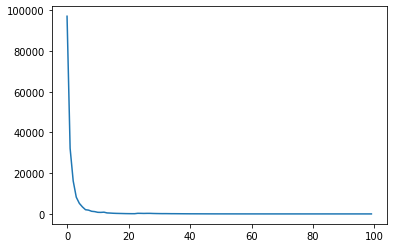

In [9]:
plt.plot(info_gks['Residual'])

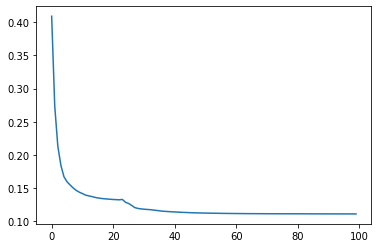

In [10]:
plt.plot(info_gks['relError'])

In [11]:
info_gks['relError']

[0.4090157371511155,
 0.2733165135001411,
 0.21308334089555145,
 0.18416748091276539,
 0.16687651025119846,
 0.159352996972001,
 0.15445113759967907,
 0.1499681265695046,
 0.14631246351648075,
 0.14358094390209217,
 0.141543525654357,
 0.13925174626690046,
 0.13811192335282343,
 0.1370958876103089,
 0.13587790968498945,
 0.134980569784073,
 0.13425627703254556,
 0.13373894122777472,
 0.13332448758867038,
 0.13296988063383203,
 0.13262964455063056,
 0.13234763524735885,
 0.13211769375357443,
 0.1326801958041775,
 0.12846072674734454,
 0.12665021488108502,
 0.12375451783355106,
 0.1204611517598895,
 0.11916878799370856,
 0.11846664503808403,
 0.1179744182275277,
 0.11758407203038543,
 0.11728349113707749,
 0.11672166763335344,
 0.1161625899476473,
 0.11558073545451068,
 0.11497316608733069,
 0.11465569921131982,
 0.11435187517389521,
 0.11406171977185885,
 0.11381884299402051,
 0.11357954150536194,
 0.11333675686215823,
 0.11312732950276405,
 0.11292936990308487,
 0.11270615565093953,
 0

In [12]:
b_vec = d.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


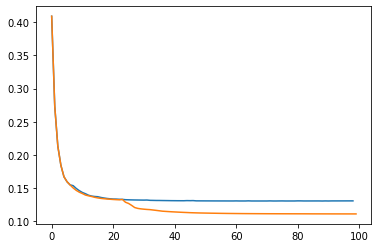

In [13]:
plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_gks['relError'])

(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f8f810bc370>)

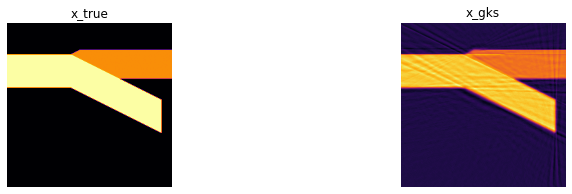

In [14]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

#### Solve the problem with MMGKS

In [22]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =100, regparam = 'dp', x_true = x_true.reshape((-1,1)), delta = delta, epsilon = 0.1)

generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


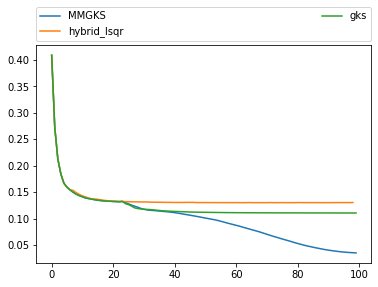

In [23]:
plt.plot(info_mmgks['relError'], label = 'MMGKS')
plt.plot(info_hybrid_lsqr['relError'], label='hybrid_lsqr')
plt.plot(info_gks['relError'], label = 'gks')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

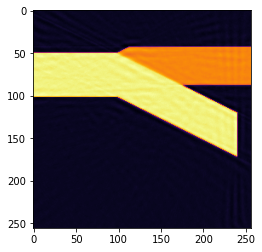

In [24]:
plt.imshow(x_mmgks.reshape((nx,ny)))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f8f4203fb20>)

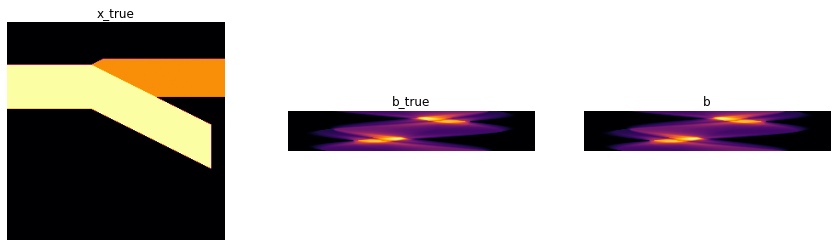

In [18]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(d.reshape((p,q)))

## Illustrate derivative and framelet operator with MMGKS

In [16]:
# Compute a solution by MMGKS
# Define a derivative operator as a regularization operator
L = create_framelet_operator(nx, ny, 2)
data_vec = d.reshape((-1,1))
# Use MMGKS to compute an approximate solution
(x_mmgks_framelet, info_mmgks_framelet) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =100, regparam = 'gcv', x_true = x_true.reshape((-1,1)), delta = delta, epsilon = 0.1)

/Users/mirjetapasha/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 100/100 [12:00<00:00,  7.21s/it]


In [17]:
# Compute a solution by MMGKS
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use MMGKS to compute an approximate solution
(x_mmgks_derivative, info_mmgks_derivative) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =100, regparam = 'gcv', x_true = x_true.reshape((-1,1)), delta = delta, epsilon = 0.1)

generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


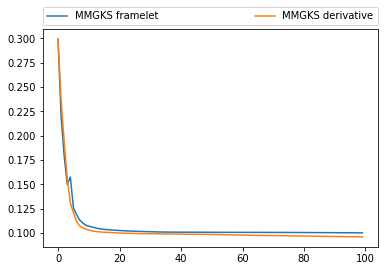

In [18]:
plt.plot(info_mmgks_framelet['relError'], label = 'MMGKS framelet')
plt.plot(info_mmgks_derivative['relError'], label = 'MMGKS derivative')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()